In [1]:
from keras.models import load_model
model = load_model('Controls_and_Patients_small.h5')

Using TensorFlow backend.


In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 88, 78, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 39, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 18, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 6, 128)         147584    
__________

In [8]:
img_path = 'image.png'
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [9]:
img = image.load_img(img_path, target_size=(90,80))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [10]:
print(x.shape)

(1, 90, 80, 3)


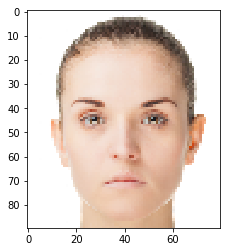

In [12]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [13]:
preds = model.predict(x)
preds

array([[ 0.]], dtype=float32)

In [14]:
argmax = np.argmax(preds[0])
argmax

0

In [15]:
output = model.output[:,argmax]
print(output.shape)
output

(?,)


<tf.Tensor 'strided_slice:0' shape=(?,) dtype=float32>

In [16]:
last_conv_layer = model.get_layer('conv2d_4')
last_conv_layer

In [17]:
from keras import backend as K
grads = K.gradients(output, last_conv_layer.output)[0]
grads

<tf.Tensor 'gradients/max_pooling2d_4/MaxPool_grad/MaxPoolGrad:0' shape=(?, 7, 6, 128) dtype=float32>

In [18]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))
pooled_grads

<tf.Tensor 'Mean:0' shape=(128,) dtype=float32>

In [19]:
iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])

In [20]:
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

In [21]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

/home/dua/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


/home/dua/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


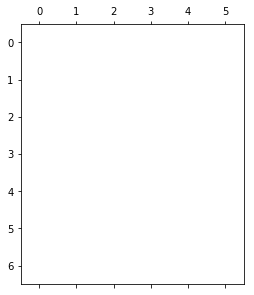

In [23]:
import matplotlib.pyplot as plt
plt.matshow(heatmap)

In [24]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

In [25]:
CAM_output = cv2.imwrite('cam_image.png', superimposed_img)
out_img_path = 'image.png'
out_img = image.load_img(out_img_path, target_size=(90, 80))
out_img_tensor = image.img_to_array(out_img)
out_img_tensor = np.expand_dims(out_img_tensor, axis=0)
out_img_tensor /= 255.

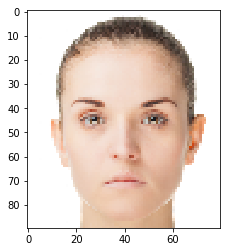

In [26]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()